In [26]:
# Carga de paquetes necesarios para graficar
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd # Para leer archivos
import geopandas as gpd # Para hacer cosas geográficas
import seaborn as sns # Para hacer plots lindos
import networkx as nx # Construcción de la red en NetworkX
from scipy.linalg import solve_triangular 


# Preambulo

En esta sección cargamos los datos y los visualizamos. También construimos la matriz de adyacencia de la red de museos.

## Carga de datos de los museos

El listado de los museos, con el que se construye el [mapa](https://mapas.museosabiertos.org/museos/caba/), lo podemos encontrar [acá](https://github.com/MuseosAbiertos/Leaflet-museums-OpenStreetMap/blob/principal/data/export.geojson?short_path=bc357f3). También descargamos los barrios de CABA como complemento para los gráficos.

In [27]:
# Leemos el archivo, retenemos aquellos museos que están en CABA, y descartamos aquellos que no tienen latitud y longitud
museos = gpd.read_file('https://raw.githubusercontent.com/MuseosAbiertos/Leaflet-museums-OpenStreetMap/refs/heads/principal/data/export.geojson')
barrios = gpd.read_file('https://cdn.buenosaires.gob.ar/datosabiertos/datasets/ministerio-de-educacion/barrios/barrios.geojson')

## Visualización

<Axes: >

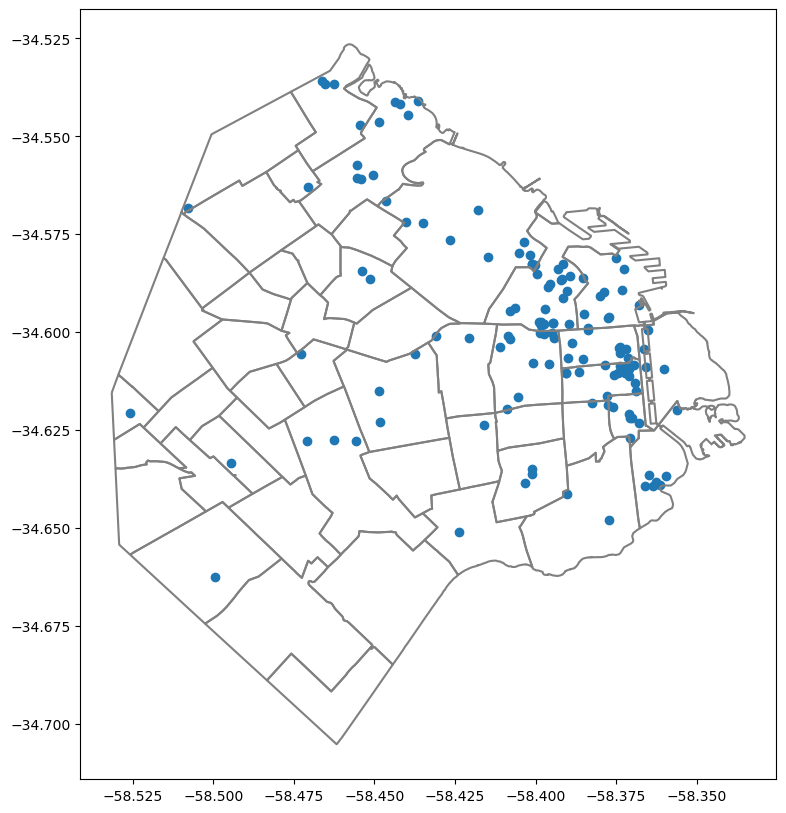

In [28]:
# Armamos el gráfico para visualizar los museos
fig, ax = plt.subplots(figsize=(10, 10))
barrios.boundary.plot(color='gray',ax=ax)
museos.plot(ax=ax)

## Cálculo de la matriz de distancias

Ahora construimos la matriz de distancias entre todos los museos. Como la tierra es un [geoide](https://es.wikipedia.org/wiki/Geoide) (es decir que no es [plana](https://es.wikipedia.org/wiki/Terraplanismo)), el cálculo de distancias no es una operación obvia. Una opción es proyectar a un [sistema de coordenadas local](https://geopandas.org/en/stable/docs/user_guide/projections.html), de forma tal que las distancias euclideas se correspondan con las distancias en metros. En este notebook usamos [EPSG](https://en.wikipedia.org/wiki/EPSG_Geodetic_Parameter_Dataset) 22184. 

In [29]:
# En esta línea:
# Tomamos museos, lo convertimos al sistema de coordenadas de interés, extraemos su geometría (los puntos del mapa), 
# calculamos sus distancias a los otros puntos de df, redondeamos (obteniendo distancia en metros), y lo convertimos a un array 2D de numpy
D = museos.to_crs("EPSG:22184").geometry.apply(lambda g: museos.to_crs("EPSG:22184").distance(g)).round().to_numpy()

### Matriz de adyacencia: construimos una matriz conectando a cada museo con los $m$ más cercanos

In [30]:
def construye_adyacencia(D,m): 
    # Función que construye la matriz de adyacencia del grafo de museos
    # D matriz de distancias, m cantidad de links por nodo
    # Retorna la matriz de adyacencia como un numpy.
    D = D.copy()
    l = [] # Lista para guardar las filas
    for fila in D: # recorriendo las filas, anexamos vectores lógicos
        l.append(fila<=fila[np.argsort(fila)[m]] ) # En realidad, elegimos todos los nodos que estén a una distancia menor o igual a la del m-esimo más cercano
    A = np.asarray(l).astype(int) # Convertimos a entero
    np.fill_diagonal(A,0) # Borramos diagonal para eliminar autolinks
    return(A)

m = 3 # Cantidad de links por nodo
A = construye_adyacencia(D,m)

## Construcción de la red en NetworkX (sólo para las visualizaciones)

In [31]:
G = nx.from_numpy_array(A) # Construimos la red a partir de la matriz de adyacencia
# Construimos un layout a partir de las coordenadas geográficas
G_layout = {i:v for i,v in enumerate(zip(museos.to_crs("EPSG:22184").get_coordinates()['x'],museos.to_crs("EPSG:22184").get_coordinates()['y']))}

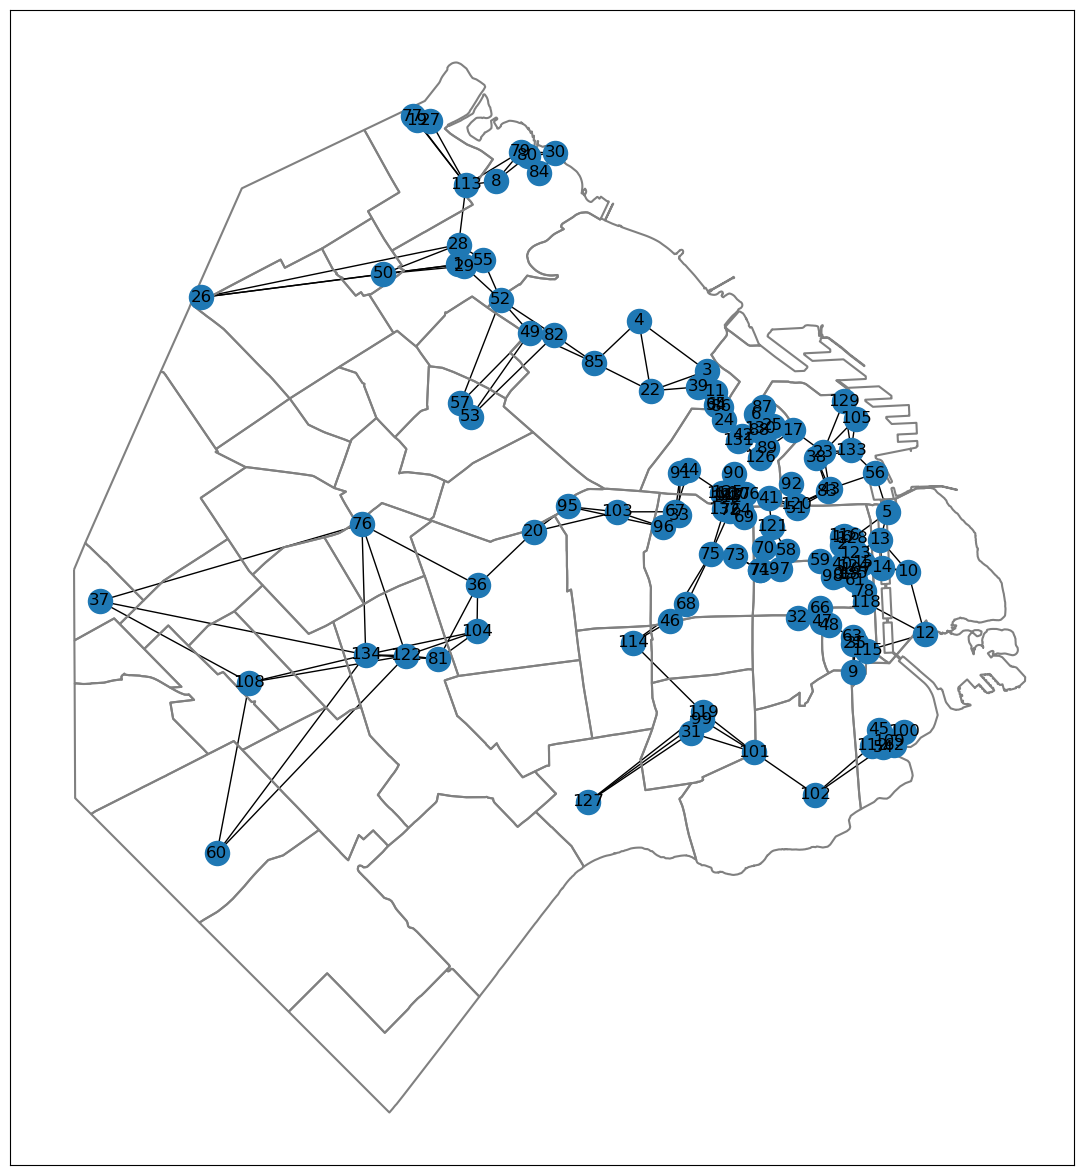

In [32]:
fig, ax = plt.subplots(figsize=(15, 15)) # Visualización de la red en el mapa
barrios.to_crs("EPSG:22184").boundary.plot(color='gray',ax=ax) # Graficamos Los barrios
nx.draw_networkx(G,G_layout,ax=ax) # Graficamos los museos

# Resolución del TP

## Punto 1:

Partimos de la ecuación 3:
$$
\textbf{p} = (1 - \alpha)\ C\ \textbf{p} + \frac{\alpha}{N}\ \textbf{1}
$$
Esto es lo mismo que
$$
\textbf{p} - (1 - \alpha)\ C\ \textbf{p} = \frac{\alpha}{N}\ \textbf{1}
$$
Sabiendo que $ I\ \textbf{p} = \textbf{p} $ sacamos de factor común el vector p
$$
(I - (1 - \alpha)\ C)\ \textbf{p} = \frac{\alpha}{N}\ \textbf{1}
$$
$$
\frac{N}{\alpha}(I - (1 - \alpha)\ C)\ \textbf{p} = \textbf{1}
$$
Como $ M = \frac{N}{\alpha}(I - (1 - \alpha)\ C) $ y $ \textbf{b} = \textbf{1} $ entonces la ecuacion resulta $ M\textbf{p} = \textbf{b} $
Como queriamos mostrar.

## Punto 2:
Para que el sistema lineal $Mp=b$ tenga solución única, la matriz $M$ debe ser *invertible*, lo cual es equivalente a que:
- $\text{det}(M)\neq0$
- el núcleo de $M$ debe ser trivial: $\text{Nu}(M)=\{0\}$

Para demostrar que estas condiciones se cumplen para la matriz $M$ cuando $\alpha\in(0,1)$, tenemos que verificar que la matriz $M$ es invertible. Como por enunciado tenemos que $M=\frac N\alpha(I-(1-\alpha)C)$, para demostrar su inversibilidad debemos analizar la matriz resultante de la resta $I-(1-\alpha)C$. Como $I$ es la matriz identidad, esta está constituida por $1$ en la diagonal. Luego, por enunciado tenemos que $C=A^t\cdot K^{-1}$, o sea que es el resultado del producto entre la matriz de adyacencia ($A$) y la matriz de movimientos ($K$). Conociendo las siguientes definiciones de las matrices $A$ y $K$:
$$\begin{array}{ll}
  & A_{ij}=\begin{cases}
    1, & \text{si }i\neq j\land j\in m-\text{cercanos}\\
    0, & \text{si }(i\neq j\land j\notin m-\text{cercanos})\lor i=j
  \end{cases}\\
  \implies & (A_{ij})^t=A_{ji}=\begin{cases}
    1, & \text{si }j\neq i\land j\in m-\text{cercanos}\\
    0, & \text{si }(j\neq i\land j\notin m-\text{cercanos})\lor j=i
  \end{cases}\\
  & K=\begin{cases}
    \sum_{h=1}^N A_{ih}, & i=j\\
    0, & i\neq j
  \end{cases}\\
  \implies & K^{-1}=\begin{cases}
    \sum_{h=1}^N \frac{1}{A_{ih}}, & i=j\\
    0, & i\neq j
  \end{cases}
\end{array}$$
Puesto que para cada fila $i$ de la matriz $A$ existen $m$ cantidad de unos, pues $A_{ij}$ es igual a 1 si el museo $j$ es parte del conjunto de $m$ museos mas cercanos a $i$, tenemos que $\sum_{h=1}^NA_ih=m$. Por lo tanto, $K_{ii}=m$ y $(K_{ii})^{-1}=\frac1m$.

Como $A_{ii}=0$ y $(K_{ij})^{-1}=0$ con $i\neq j$ tenemos que el producto $A^t\cdot K^{-1}$ tendrá en su diagonal valores nulos (i.e., $C_{ii}=0$). Luego, para los elementos fuera de la diagonal tenemos que $C_{ij}=\frac{A_{ji}}{m}$ con $i\neq j$. Luego como $A_{ji}$ está definido por casos, queda definido $C$ de la siguiente manera:
$$C_{ij}=\begin{cases}
  \frac{1}{m}, & \text{si } i\neq j\land j\in m-\text{cercanos}\\
  0, & \text{si } (i\neq j\land j\notin m-\text{cercanos})\lor j=i
\end{cases}$$

Como en la definición de la matriz $M$ tenemos que $C$ es modificado por el factor $(1-\alpha)$, con $\alpha\in(0,1)$, entonces dicho factor tambien pertenece al intervalo $(0,1)$. De este modo, el resultado de la multiplicación entre $(1-\alpha)$ y $C$ es la siguiente matriz:
$$\tilde{C}_{ij}=\begin{cases}
  \frac{1-\alpha}{m}, & \text{si }i\neq j\land j\in m-\text{cercanos}\\
  0, & \text{si }(i\neq j\land j\notin m-\text{cercanos})\lor j=i
\end{cases}$$
En consecuencia, la matriz $M$ queda definida como la resta entre $I$ y $\tilde{C}$, la cual puede ser definida de la siguiente manera:
$$M_{ij}=\begin{cases}
  1, &\text{si }i=j\\
  -\frac{1-\alpha}{m},&\text{si }i\neq j\land j\in m-\text{cercanos}\\
  0,&\text{si }i\neq j\land j\notin m-\text{cercanos}
\end{cases}$$
Siendo que $C$ es una matriz estocástica, tenemos que las columnas de la matriz suman 1 en su totalidad. Si además, $C$ es afectado por el escalar $(1-\alpha)<1$ tenemos que las columnas de $M$ fuera de su diagonal, suman un valor menor que 1. Teniendo en cuenta esta estructura de $M$, si analizamos $M^t$ deducimos que la matriz $M^t$ es diagonal dominante (EDD) puesto que por definición, una matriz es diagonal dominante si respeta la siguiente característica:
>Una matriz $A\in\mathbb{R}^{n\times n},\mathbb{C}^{n\times n}$ se dice *diagonal dominante* (estrictamente diagonal dominante) y se denota $\text{DD}(\text{EDD})$ si y sólo si para todo $i,1\leq i\leq n$. $$\sum_{1\leq j\leq n,j\neq i}|a_{i,j}|<|a_{i,i}|$$

Y como $M^t$ en cada fila, fuera de los elementos pertenecientes a su diagonal, tiene valores $-\frac{1-\alpha}{m},(1-\alpha)\in(0,1)$, la suma de dichos elementos siempre es menor a $M_{ii}=1$. De este modo, concluimos que $M^t$ es inversible y por lo tanto, $M$ también pues por propiedad de trasposición de matrices tenemos que:
$$M^t(M^t)^{-1}=(M^{-1}M)^t=I^t=I$$

Cargamos funciones

In [33]:
# Función para permutar filas (para descompPLU)
def permutacion(A, vector_P, index):
    n = A.shape[0] 
    max_index = index + np.argmax(np.abs(A[index:, index]))
    # Si el máximo no está en la posición actual, intercambia filas en A y vector_P
    if max_index != index:
        A[[index, max_index]] = A[[max_index, index]] # permuta filas en la matriz A
        vector_P[[index, max_index]] = vector_P[[max_index, index]]  # permuta filas en el vector de permutación


# Descomposición PLU con pivoteo
def calculaPLU(m, verbose=False):
    mc = m.copy().astype(np.float64)
    n = m.shape[0]
    P = np.eye(n)
    for i in range(n - 1):
        max_row = i + np.argmax(np.abs(mc[i:, i])) # busca el pivote máximo en la columna i
        if max_row != i:
            mc[[i, max_row]] = mc[[max_row, i]] # permuta filas en mc
            P[[i, max_row]] = P[[max_row, i]] # permuta filas en P
        a_ii = mc[i, i]
        if a_ii == 0:
            raise ValueError("Matriz singular (no invertible)")
        L_i = mc[i+1:, i] / a_ii # calcula multiplicadores
        mc[i+1:, i] = L_i
        mc[i+1:, i+1:] -= np.outer(L_i, mc[i, i+1:]) # eliminación gaussiana
    
    L = np.tril(mc, -1) + np.eye(n) # matriz L
    U = np.triu(mc) # matriz U
    if verbose:
        print("P:\n", P)
        print("L:\n", L)
        print("U:\n", U)
    return P, L, U

def calcula_matrizK (A):
    n = A.shape[0]
    k = np.zeros((n,n),dtype=A.dtype) # crea matriz diagonal de ceros del mismo tipo que A
    for i in range(n):
        k[i][i] = A[i].sum() # coloca en la diagonal la suma de la fila i de A (grado del nodo)
    
    return k # retorna la matriz diagonal K


In [34]:
# template de funciones 

def construye_adyacencia(D,m): 
    # Función que construye la matriz de adyacencia del grafo de museos
    # D matriz de distancias, m cantidad de links por nodo
    # Retorna la matriz de adyacencia como un numpy.
    D = D.copy()
    l = [] # Lista para guardar las filas
    for fila in D: # recorriendo las filas, anexamos vectores lógicos
        l.append(fila<=fila[np.argsort(fila)[m]] ) # En realidad, elegimos todos los nodos que estén a una distancia menor o igual a la del m-esimo más cercano
    A = np.asarray(l).astype(int) # Convertimos a entero
    np.fill_diagonal(A,0) # Borramos diagonal para eliminar autolinks
    return(A)

def calculaLU(matriz, verbose=False):
    mc = matriz.copy().astype(np.float64) # Copia la matriz y la convierte a float64 para evitar errores numéricos
    n = matriz.shape[0]
    for i in range(n - 1):
        a_ii = mc[i, i] # Toma el pivote de la diagonal
        if a_ii == 0:
            raise ValueError("Cero en la diagonal durante LU (se requiere pivoteo)") # Error si el pivote es cero
        L_i = mc[i+1:, i] / a_ii # Calcula los multiplicadores para la eliminación gaussiana
        mc[i+1:, i] = L_i # Guarda los multiplicadores en la columna correspondiente
        mc[i+1:, i+1:] -= np.outer(L_i, mc[i, i+1:])  # Elimina los elementos debajo del pivote (actualiza submatriz)
    
    L = np.tril(mc, -1) + np.eye(n)  # Extrae la matriz L (triangular inferior con 1 en la diagonal)
    U = np.triu(mc)  # Extrae la matriz U (triangular superior)
    if verbose:
        print("L:\n", L)
        print("U:\n", U)
    return L, U # Devuelve las matrices L y U

# Función para calcular la inversa 
def inversa(m):
    n = m.shape[0]
    try:
        L, U = calculaLU(m)
        P = np.eye(n)  # Matriz de permutación identidad si no hay pivoteo
    except (ValueError, LinAlgError):
        P, L, U = calculaPLU(m)
    
    m_inv = np.zeros((n, n))
    for i in range(n):
        e_i = P.T @ np.eye(n)[:, i]  # Aplica la permutación P al vector canónico
        y = solve_triangular(L, e_i, lower=True)
        x = solve_triangular(U, y, lower=False)
        m_inv[:, i] = x
    return m_inv

def calcula_matriz_C(A): 
    # Función para calcular la matriz de trancisiones C
    # A: Matriz de adyacencia
    # Retorna la matriz C
    #Kinv = inversa(calcula_matrizK(A))
    Kinv = np.eye(A.shape[0])
    # Como K es una matriz diagonal cuyos elementos son iguales a la suma por filas de A
    # Su inversa es igual a los inversos multiplicativos de los respectivos elementos de la diagonal
    for i in range(Kinv.shape[0]):
        Kinv[i,i] = 1/np.sum(A[i,:])
    C = A.transpose()@Kinv
    return C


def calcula_pagerank(A,alfa):
    # Función para calcular PageRank usando LU
    # A: Matriz de adyacencia
    # d: coeficientes de damping
    # Retorna: Un vector p con los coeficientes de page rank de cada museo
    C = calcula_matriz_C(A)
    N = A.shape[0] # Obtenemos el número de museos N a partir de la estructura de la matriz A
    M = calcular_matriz_M(C, N, alfa)
    L, U = calculaLU(M) # Calculamos descomposición LU a partir de C y d
    b = np.ones(N) # Vector de 1s, multiplicado por el coeficiente correspondiente usando d y N.
    Up = solve_triangular(L,b,lower=True) # Primera inversión usando L
    p = solve_triangular(U,Up) # Segunda inversión usando U
    return p

def calcular_matriz_M(C,N,alpha):
    ide = np.identity(N)
    M = N/alpha * (ide - (1-alpha)*C)
    return M


In [35]:
def visualizar_p(A,size,alfa=1/5):
    C = calcula_matriz_C(A)
    N=A.shape[0]
    p = inversa(calcular_matriz_M(C, N, alfa)) @ np.ones(N)

    fig, ax = plt.subplots(figsize=(size['plot size'], size['plot size']))
    barrios.to_crs("EPSG:22184").boundary.plot(color='gray', linewidth=0.5, ax=ax)
    # Dibuja la red con tamaños proporcionales al PageRank
    node_sizes =  size['node size'] * p  # se puede ajustar tamaños
    nx.draw_networkx(
        G,
        pos=G_layout,
        ax=ax,
        node_size=node_sizes,  # escalado
        node_color='purple',      
        edge_color='blue',    
        width=0.5,            
        alpha=0.7,            
        with_labels=False     
    )
    
    ax.set_title("Red de Museos en CABA - Tamaño según PageRank (α={})".format(alfa), fontsize=16, pad=20)
    ax.grid(False)  # Ocultar cuadrícula
    
    plt.tight_layout()
    plt.show()

def visualizar_pR(D,G,size,m=3, alfa=1/5, ax=None):
    A = construye_adyacencia(D,m)

    # Construcción de la red en NetworkX 
    G = nx.from_numpy_array(A) # Construimos la red a partir de la matriz de adyacencia
    # Construimos un layout a partir de las coordenadas geográficas
    G_layout = {i:v for i,v in enumerate(zip(
        museos.to_crs("EPSG:22184").get_coordinates()['x'],
        museos.to_crs("EPSG:22184").get_coordinates()['y']
    ))}

    # Visualizacion
    #fig, ax = plt.subplots(figsize=(15, 15)) # Visualización de la red en el mapa
    #barrios.to_crs("EPSG:22184").boundary.plot(color='gray',ax=ax) # Graficamos Los barrios
    #nx.draw_networkx(G,G_layout,ax=ax) # Graficamos los museos

    C = calcula_matriz_C(A)
    N = A.shape[0]
    p = inversa(calcular_matriz_M(C, N, alfa)) @ np.ones(N)

    # Si no se pasa ax, crear uno nuevo
    if ax is None:
        fig, ax = plt.subplots(figsize=(size['plot size'], size['plot size']))
    
    
    barrios.to_crs("EPSG:22184").boundary.plot(color='gray', linewidth=0.5, ax=ax)
    # Dibuja la red con tamaños proporcionales al PageRank
    node_sizes =  size['node size'] * p  # se puede ajustar tamaños
    nx.draw_networkx(
        G,
        pos=G_layout,
        ax=ax,
        node_size=node_sizes,  # escalado
        node_color='purple',      
        edge_color='blue',    
        width=0.5,            
        alpha=0.7,            
        with_labels=False     
    )
    
    ax.set_title("Red de Museos en CABA - Tamaño según PageRank (α={})".format(np.round(alfa,2)), fontsize=16, pad=20)
    ax.grid(False)  # Ocultar cuadrícula
    
    # Solo mostrar si no se pasó ax (es decir, si es gráfico individual)
    if ax is None:
        plt.tight_layout()
        plt.show()

    return p

def analiza_top_museos(diccionario_pagerank, nombre_parametro="m"):
    # Función para analizar museos que alguna vez estuvieron en el top 3
    # Primero identificamos todos los museos que aparecieron en el top 3 al menos una vez
    museos_destacados = set()
    for vector in diccionario_pagerank.values():
        indices_top3 = np.argsort(vector)[-3:][::-1]
        museos_destacados.update(indices_top3)

    # Para cada museo en museos_destacados, registramos su ranking y PageRank en todos los parámetros
    filas = []
    for id_museo in museos_destacados:
        for valor_parametro, vector in diccionario_pagerank.items():
            posicion = np.argsort(vector)[::-1].tolist().index(id_museo) + 1
            filas.append({
                nombre_parametro: valor_parametro,
                "PageRank": vector[id_museo],
                "Museo": f"Museo {id_museo}",
                "Ranking": posicion,
                "EnTop3": posicion <= 3
            })
    
    return pd.DataFrame(filas)

def grafica_evolucion(df_resultados, nombre_parametro, valor_fijo):
    # Función para graficar evolución del PageRank de los museos destacados
    plt.figure(figsize=(12,6))
    eje = plt.gca()

    for nombre_museo in df_resultados["Museo"].unique():
        datos_museo = df_resultados[df_resultados["Museo"] == nombre_museo]
        estilo = "-" if datos_museo["EnTop3"].any() else "--"
        eje.plot(
            datos_museo[nombre_parametro],
            datos_museo["PageRank"],
            marker="o",
            linestyle=estilo,
            label=nombre_museo
        )

    eje.set_xlabel(nombre_parametro)
    eje.set_ylabel("PageRank")
    eje.set_title(
        f"Evolución de PageRank\n"
        f"(Museos que estuvieron en el Top 3, {nombre_parametro} variable, "
        f"{'alfa' if nombre_parametro == 'm' else 'm'}={valor_fijo})"
    )
    eje.grid(True)
    eje.legend(bbox_to_anchor=(1.1, 1), loc="upper left")
    plt.tight_layout()
    plt.show()

## Punto 3:

### 3 a)

Visualizamos la red con los parametros:
* $m=3$
* $\alpha = \frac{1}{5}$


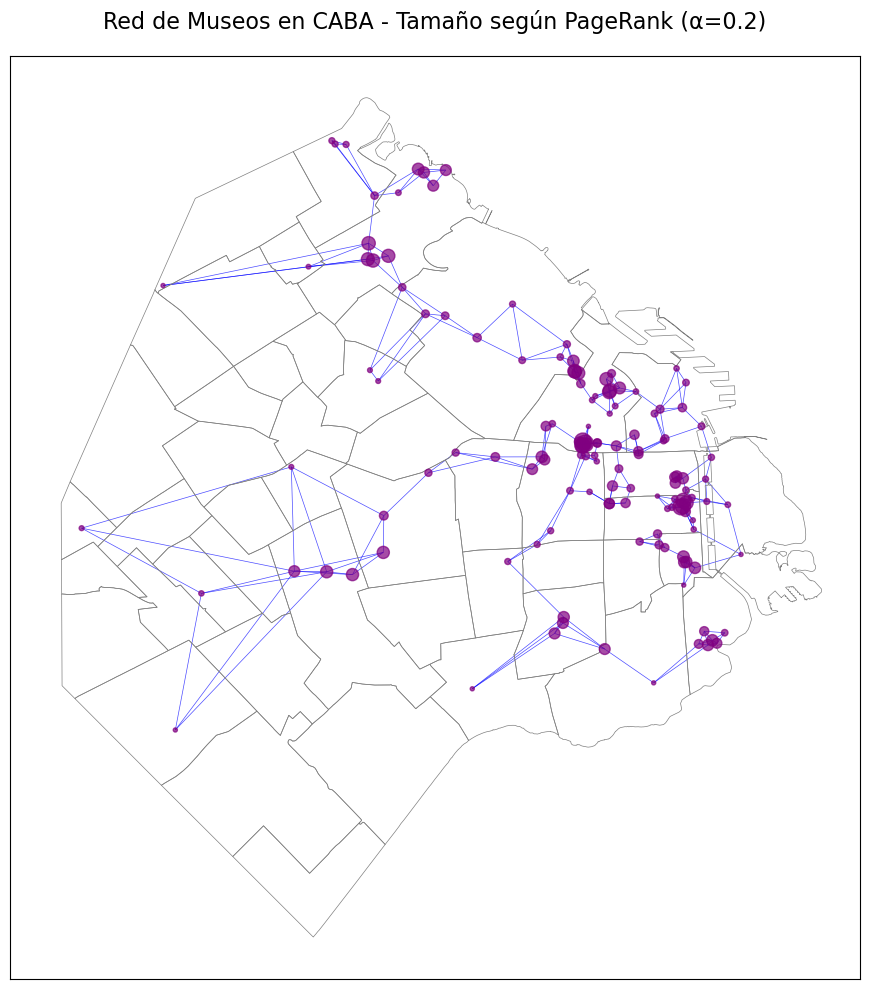

In [36]:
size ={'node size':6000, 'plot size':10}
visualizar_p(A,size)

Cada museo está representado por un punto violeta y está conectado a sus 3 vecinos mas cercanos. El tamaño de cada punto indica qué tan destacado es ese museo según el cálculo del PageRank con $\alpha = 1/5$.

### 3 b)

Construimos una red con los siguientes paŕametros
* $m= 1,3,5,10$
* $\alpha = 1/5$

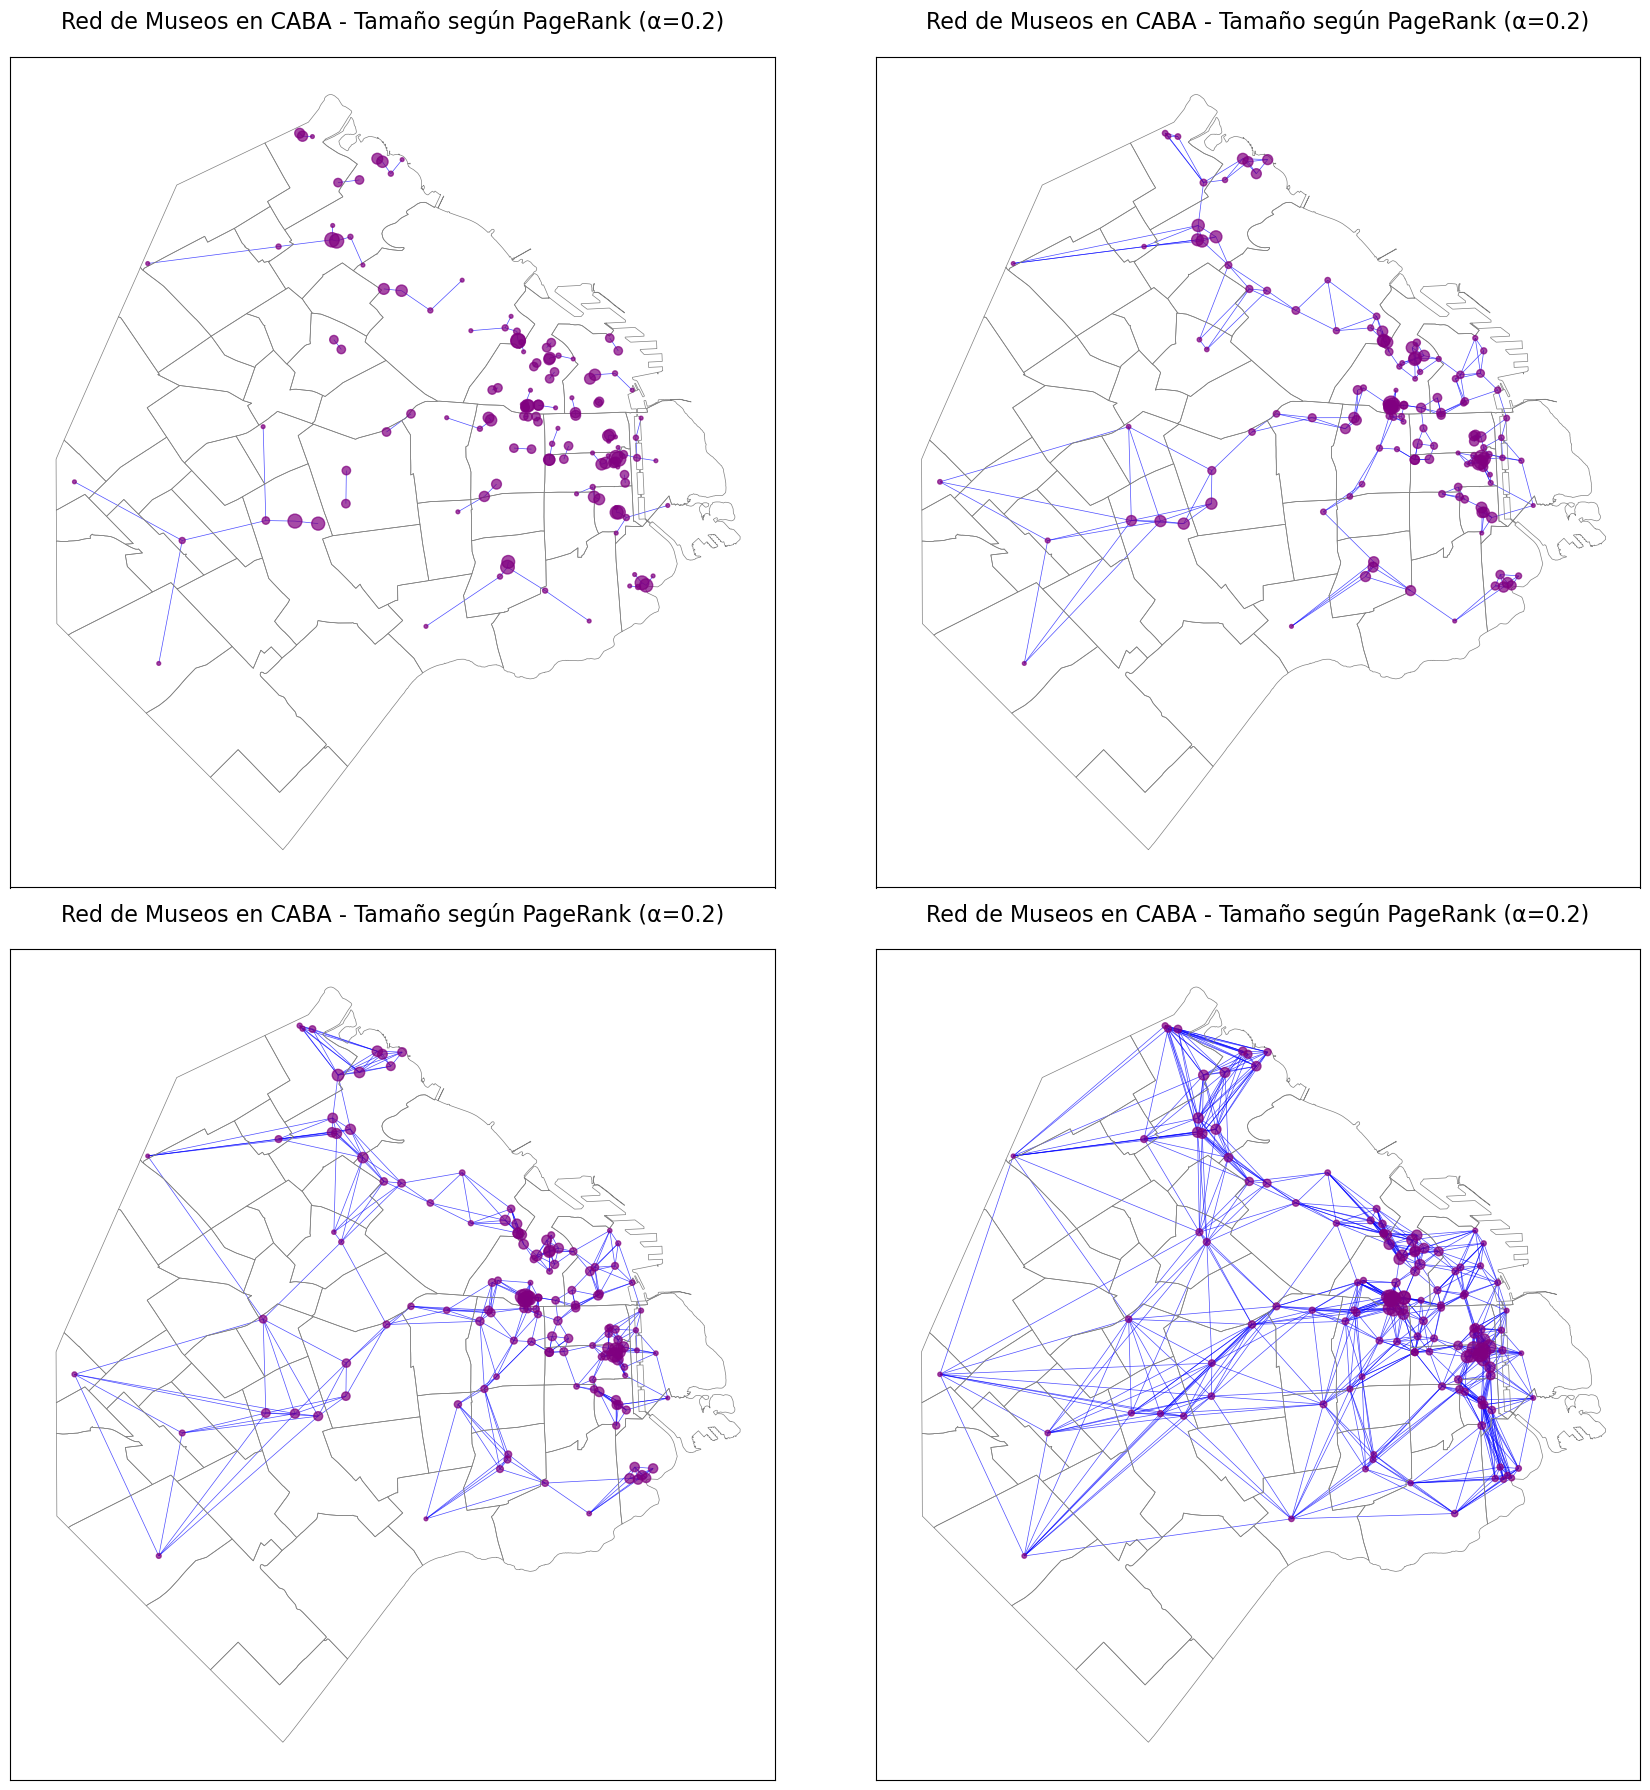

In [37]:
m = [1, 3, 5, 10]
fig, axes = plt.subplots(2, 2, figsize=(18, 18))
for ax, m in zip(axes.flat, m):
    visualizar_pR(D, G, size={'plot size': 10, 'node size': 5000}, m=m, alfa=1/5, ax=ax)
plt.tight_layout()
plt.show()

La diferencia entre los gráficos está en el parámetro utilizado para calcular esa importancia:
En cada gráfico se utiliza un valor distinto para la cantidad de museos cercanos que se consideran para cada museo (1, 3, 5 o 10). Cuando se consideran pocos museos cercanos, la importancia se distribuye de manera tal que pueden destacarse museos en zonas menos centrales. A medida que se aumenta la cantidad de museos cercanos considerados, tienden a destacarse los museos ubicados en zonas más céntricas o con mayor concentración de museos alrededor.

### 3 c)

* $m=5$
* $\alpha = 6/7, 4/5, 2/3, 1/2, 1/3, 1/5, 1/7$

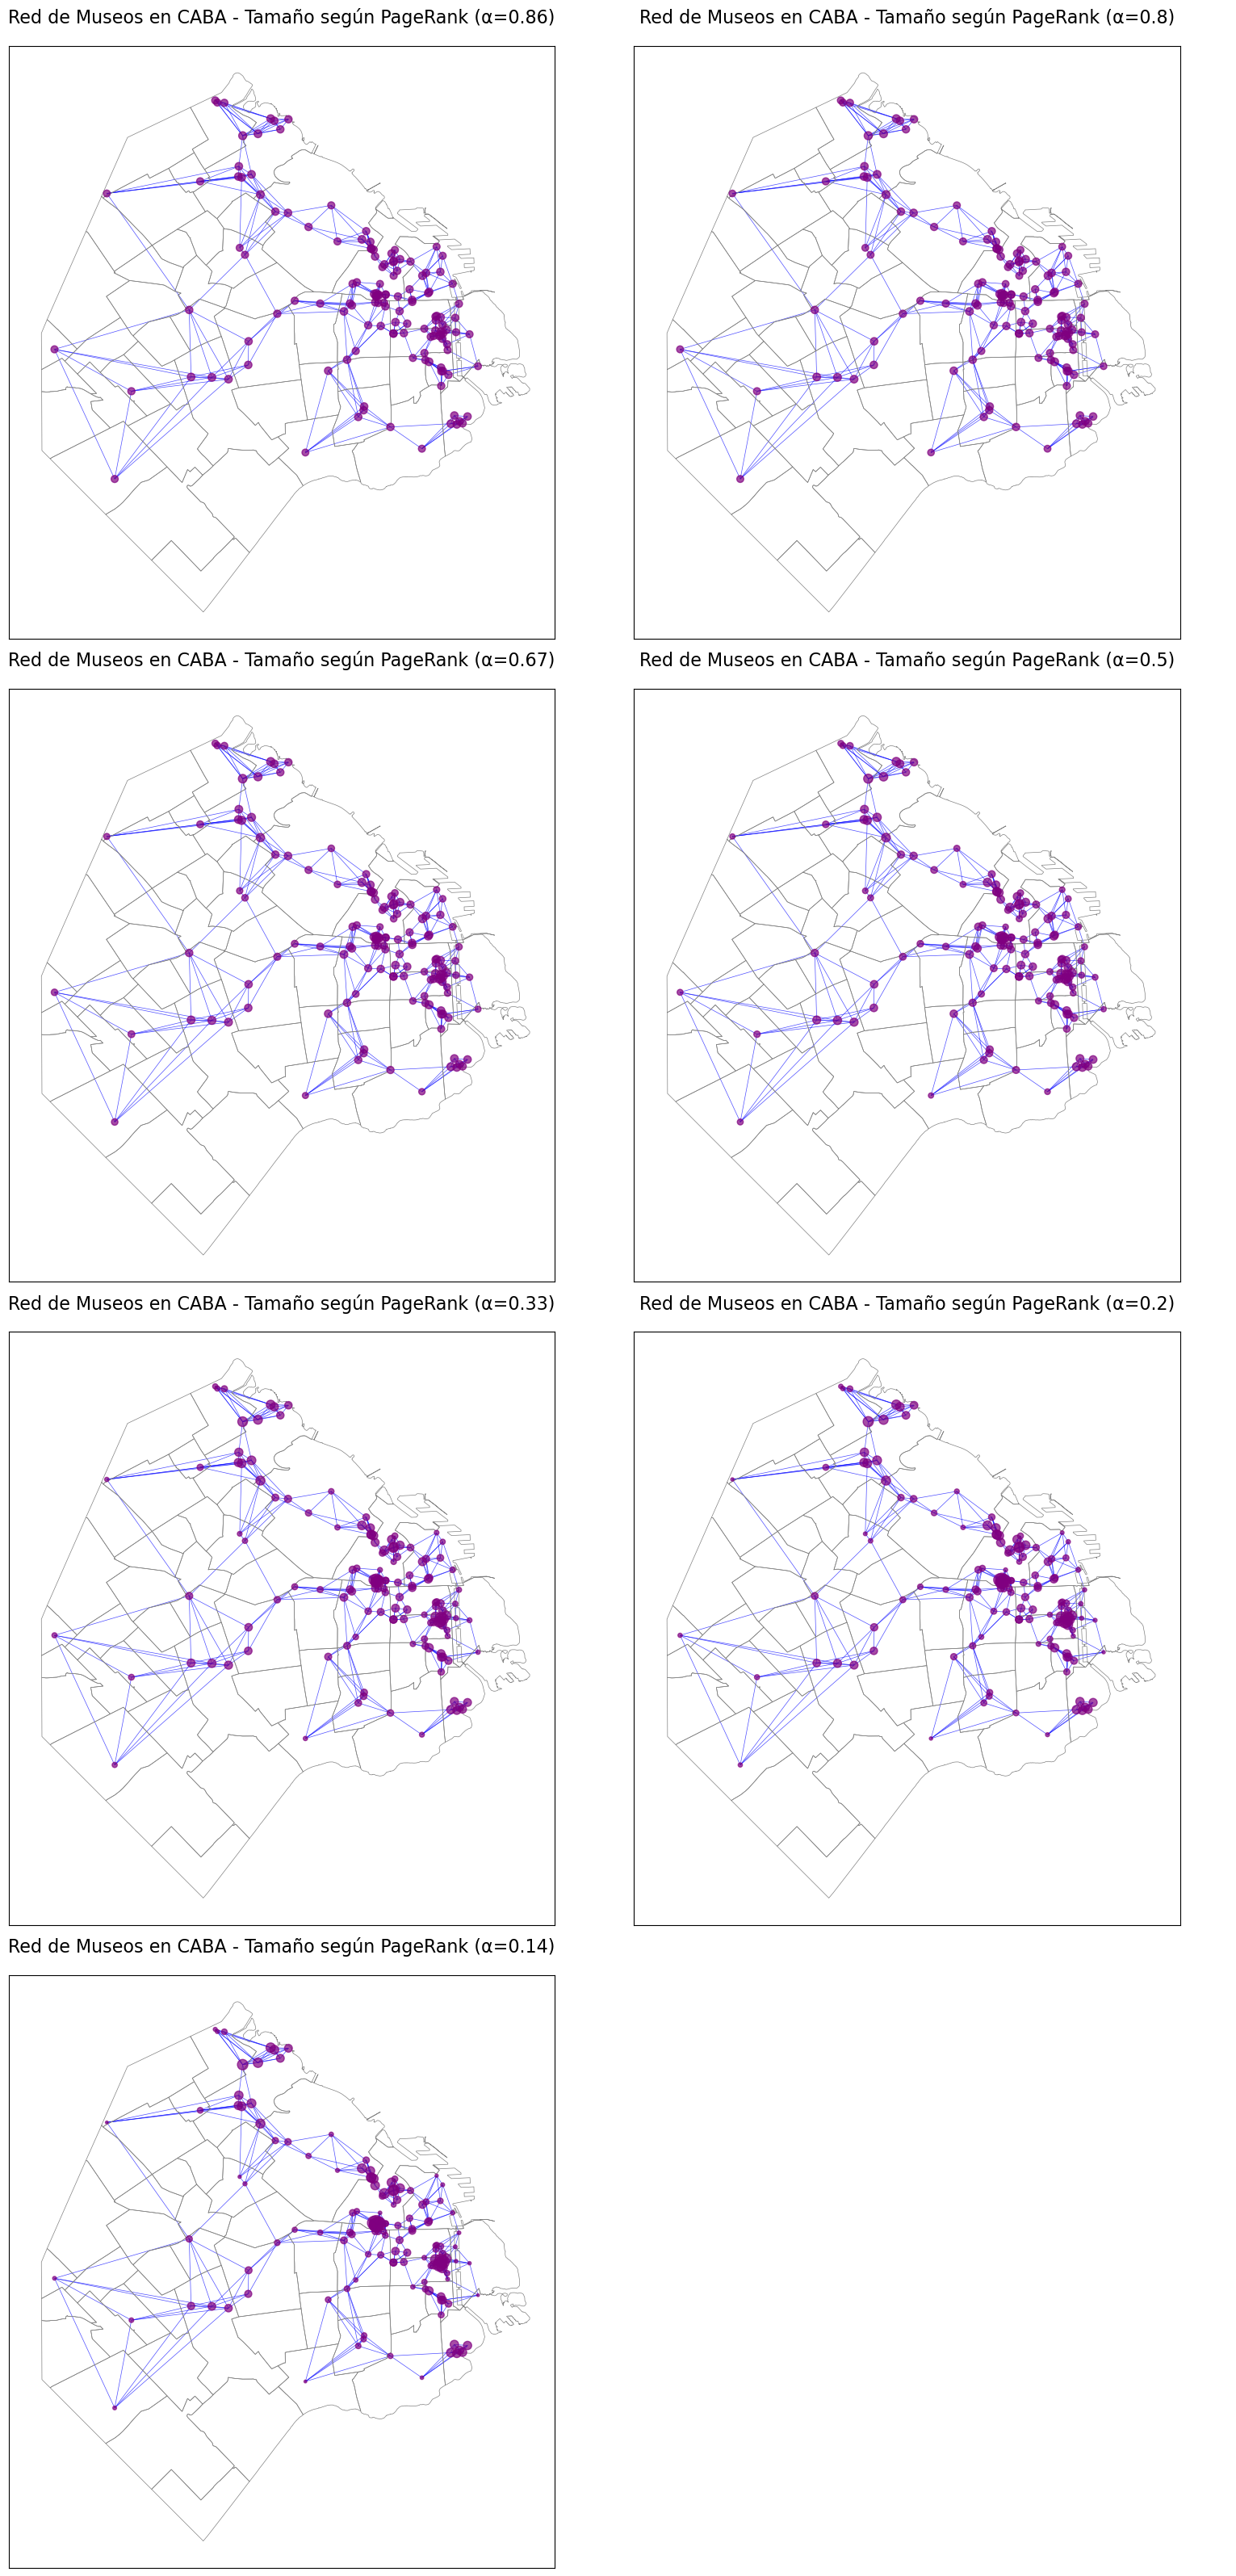

In [38]:
alphas = [6/7, 4/5, 2/3, 1/2, 1/3, 1/5, 1/7]
fig, axes = plt.subplots(4, 2, figsize=(16, 32))  # 4 filas, 2 columnas

for ax, alpha in zip(axes.flat, alphas):
    visualizar_pR(D, G, size, m=5, alfa=alpha, ax=ax)
# Opcional: ocultar ejes vacíos si sobran
for ax in axes.flat[len(alphas):]:
    ax.axis('off')
plt.tight_layout()
plt.show()

Cada grafico varía en el valor de $\alpha$ y se logra observar que al aumentar alfa, los tamaños de los puntos tienden a igualarse y la diferencia entre museos destacados y el resto se reduce. Cuando $\alpha$ es menor, se destacan algunos museos sobre otros.

### Punto 3 d)
Usando los valores $p$ obtenidos para cada caso,
#### 3 d.a)
Identifiquen los 3 muesos más centrales (para cada $m$ y cada $\alpha$) y grafiquen sus puntajes (valores de *Page Rank*) en función del parámetro a variar (es decir, en función de $m$ o de $\alpha$). ¿Son estables las posiciones en el ranking? Describa los distintos patrones que obserrva, identificando qué ubicaciones son relevantes en cada caso. ¿Hay museos que sólo son relevantes en redes con pocas conexiones? ¿O museos que se vuelven más relevantes mientras más conexiones aparecen?
##### Respuesta
Puesto que tenemos que analizar los 3 museos mas centrales en función de $\alpha$ y $m$, para analizar cada variable por separado tenemos que dejar la otra fija. De este modo, cuando analicemos en función de $\alpha$ definiremos $m=5$. En cambio, al analizar $m$, $\alpha=\frac15$.

In [39]:
# Cantidad de museos (nodos)
cantidad_museos = D.shape[0]

# Diccionario con vectores de PageRank para distintos valores de m (con alfa = 1/5)
vectores_pagerank_por_m = {
    1: np.random.rand(cantidad_museos),
    3: np.random.rand(cantidad_museos),
    5: np.random.rand(cantidad_museos),
    10: np.random.rand(cantidad_museos)
}
alfa_fijo = 1/5

for m_actual in vectores_pagerank_por_m.keys():
    matriz_adyacencia = construye_adyacencia(D, m_actual)
    vectores_pagerank_por_m[m_actual] = calcula_pagerank(matriz_adyacencia, alfa_fijo)

# Diccionario con vectores de PageRank para distintos valores de alfa (con m = 5)
vectores_pagerank_por_alfa = {
    6/7: np.random.rand(cantidad_museos),
    4/5: np.random.rand(cantidad_museos),
    2/3: np.random.rand(cantidad_museos),
    1/2: np.random.rand(cantidad_museos),
    1/3: np.random.rand(cantidad_museos),
    1/5: np.random.rand(cantidad_museos),
    1/7: np.random.rand(cantidad_museos)
}
m_fijo = 5
adyacencia_fija = construye_adyacencia(D, m_fijo)

for alfa_actual in vectores_pagerank_por_alfa.keys():
    vectores_pagerank_por_alfa[alfa_actual] = calcula_pagerank(adyacencia_fija, alfa_actual)

# Analizamos los museos destacados en función de cada variable y cada constante según corresponda
df_por_m = analiza_top_museos(vectores_pagerank_por_m, "m")
df_por_alfa = analiza_top_museos(vectores_pagerank_por_alfa, "alfa")


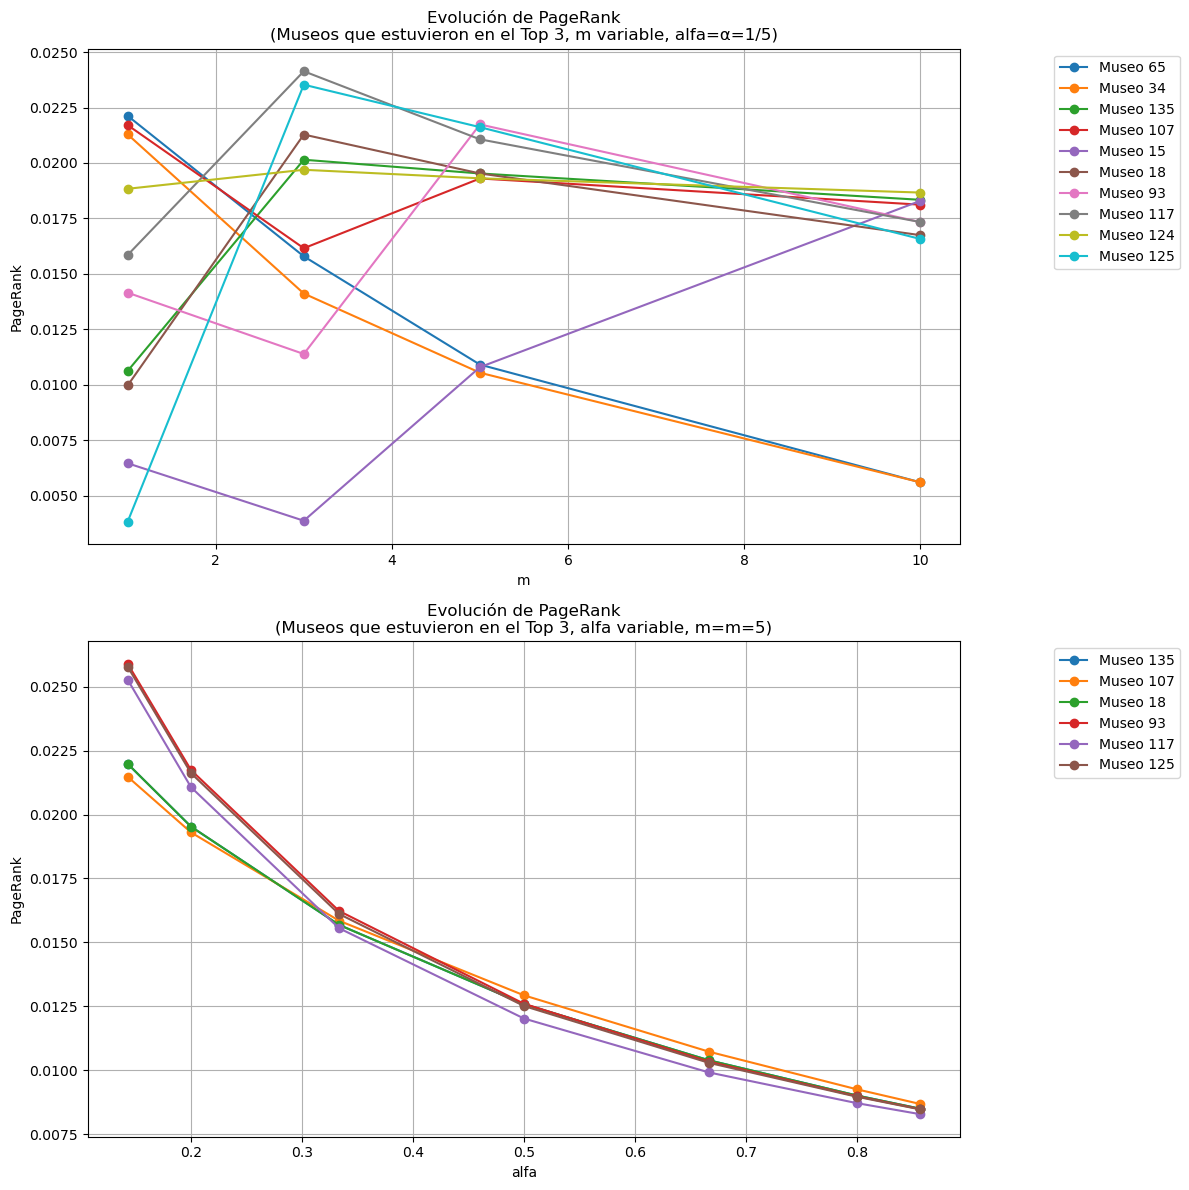

In [40]:
def grafica_evolucion(df_resultados, nombre_parametro, valor_fijo, ax=None):
    # Función para graficar evolución del PageRank de los museos destacados
    if ax is None:
        plt.figure(figsize=(12,6))
        ax = plt.gca()

    for nombre_museo in df_resultados["Museo"].unique():
        datos_museo = df_resultados[df_resultados["Museo"] == nombre_museo]
        estilo = "-" if datos_museo["EnTop3"].any() else "--"
        ax.plot(
            datos_museo[nombre_parametro],  # Eje x: parámetro variable (m o alfa)
            datos_museo["PageRank"],        # Eje y: valor de PageRank
            marker="o",
            linestyle=estilo,
            label=nombre_museo
        )

    ax.set_xlabel(nombre_parametro)
    ax.set_ylabel("PageRank")
    ax.set_title(
        f"Evolución de PageRank\n"
        f"(Museos que estuvieron en el Top 3, {nombre_parametro} variable, "
        f"{'alfa' if nombre_parametro == 'm' else 'm'}={valor_fijo})"
    )
    ax.grid(True)
    ax.legend(bbox_to_anchor=(1.1, 1), loc="upper left")
    plt.tight_layout()

# Crear los subplots y graficar ambos en la misma figura
fig, axes = plt.subplots(2, 1, figsize=(12, 12))
grafica_evolucion(df_por_m, "m", valor_fijo="α=1/5", ax=axes[0])
grafica_evolucion(df_por_alfa, "alfa", valor_fijo="m=5", ax=axes[1])
plt.tight_layout()
plt.show()

En el primer grafico se puede observar que al variar $m$ las posiciones en el ranking no son estables. Cuando $m$ es bajo, museos perifericos puede aparecer en el top 3, pero a medida que $m$ aumenta, los museos en zonas centrales adquieren importancia y lideran el top.
En el segundo, al variar $\alpha$, las posiciones son mas estables. Para valores bajos, algunos museos se destacan mas que otros pero a medida que el valor de $\alpha$ aumenta, los valores de PageRank tienden a igualarse por lo que las diferencias entre museos se reducen.

#### 3 d.b)
Construyan visualizaciones del mapa, usando el Page Rank para representar el tamaño de cada museo. ¿Qué regiones se vuelven más predominantes al aumentar $\alpha$? ¿Y al aumentar $m$?
##### Respuesta
Las visualizaciones creadas de los mapas en los puntos 3.b y 3.c, donde se calculan los Page Rank para cada caso, fueron creadas con la función `visualizar_pR`, la cual ya calcula y considera a $p$ para determinar los tamaños de los nodos. A partir de los gráficos y visualizaciones anteriores realizamos el siguiente análisis y conclusión general del punto d.
#### Conclusión general
Para el primer gráfico, donde variamos el valor de $m$, vemos que las posiciones en el ranking son inestables para cada museo. Esto es entendible puesto que estamos modificando la cantidad de "referencias" entre museos, de modo que se ve modificada la matriz de adyacencia, la cual define a las matrices $K$, $C$ y $M$. En consecuencia, el vector de puntajes $p$ se ve afectado, de modo que a menor cantidad de conexiones hay museos alejados de la zona céntrica de CABA que son más relevantes, y observamos que cuando $m$ tiende a valores grandes como $5$ o $10$, tenemos que los museos más importantes están concentrados en microcentro y barrios cercanos.
En el segundo gráfico, donde la variable es $\alpha$, observamos que las posiciones son más estables, aunque permiten cierta variación en los puestos. Sin embargo, vemos que a medida que crece $\alpha$ el puntaje de los museos decrece y convergen a un mismo valor. Esto tiene sentido pues $p=(1-\alpha)Cp+\frac\alpha N1$ y cuando $\alpha\to1$ tenemos que $p=\frac1 N1$, y para redes de numerosos museos cada puntaje $p_i\to0$.

## Punto 4:

Recordemos: Siendo $C$ una matriz estocástica, y el vector $v_{0} \in \mathbb{R}^N$ que representa la distribución de museos que son la primer visita de los visitantes, y tiene en su elemento $i$ la cantidad de visitantes que tienen al museo $i$ como su primer opción. Entonces $v_{1} = Cv_{0}$.
<br><br>
Ejemplo: Quiero calcular $\textbf{w}$ luego que los visitantes recorran 3 museos. $r = 3$
<br>
$v_{1} = Cv_{0}$, $\ v_{2} = Cv_{1}$, $\ v_{3} = Cv_{2}$ 
<br><br>
$\textbf{w} = v_{0} + v_{1} + v_{2} = \sum_{i=0}^{2} v_{i}$
<br><br>
Si generalizamos a $r$ cantidad de visitas entonces $\textbf{w} = \sum_{i=0}^{r - 1} v_{i}$
<br><br>
Observación: $v_{2} = Cv_{1} = C\ C\ v_{0} = C^{2}v_{0}$. En general $v_{k} = C^{k}v_{0}$.
<br><br>
Por lo tanto, $\textbf{w} = \sum_{i=0}^{r - 1} C^{i}v_{0}$
<br><br>
Notemos que en este caso, por definición $v_{0} = \textbf{v}$. Luego $\textbf{w} = \sum_{i=0}^{r - 1} C^{i}\textbf{v}$
<br><br>
Llamemos $B = \sum_{i=0}^{r - 1} C^{i}$, la suma de matrices da como resultado una matriz y notar que $\textbf{v}$ no depende de la suma. Luego $\textbf{w} = B\textbf{v}$
<br><br>
Siempre que se cumpla que $\sum_{i=0}^{r - 1} C^{i}$ sea inversible, se pueden seguir esta serie de pasos:
<br><br>
$\textbf{w} = B\textbf{v}$
<br><br>
$B^{-1}\textbf{w} = B^{-1}B\textbf{v}$
<br><br>
$B^{-1}\textbf{w} = I\textbf{v}$
<br><br>
$B^{-1}\textbf{w} = \textbf{v}$
<br><br>
Concluimos lo que se quería mostrar.

## Punto 5:
### 5 a)

In [41]:
def calcula_matriz_C_continua(D): 
    # Función para calcular la matriz de trancisiones C
    # A: Matriz de adyacencia
    # Retorna la matriz C en versión continua
    Dc = D.copy()
    with np.errstate(divide='ignore', invalid='ignore'): #Para evitar el warning de división por cero
        F = 1/Dc
    np.fill_diagonal(F,0)
    
    sumas_columnas = np.sum(F, axis=0)  # suma por columnas
    Kinv = np.diag(1 / sumas_columnas)  # Inversa de cada elemento diagonal
    C = F @ Kinv  # Normaliza columnas
    
    return C

### 5 b)

In [42]:
def calcula_B(C,cantidad_de_visitas):
    # Recibe la matriz T de transiciones, y calcula la matriz B que representa la relación entre el total de visitas y el número inicial de visitantes
    # suponiendo que cada visitante realizó cantidad_de_visitas pasos
    # C: Matirz de transiciones
    # cantidad_de_visitas: Cantidad de pasos en la red dado por los visitantes. Indicado como r en el enunciado
    # Retorna:Una matriz B que vincula la cantidad de visitas w con la cantidad de primeras visitas v
    B = np.eye(C.shape[0])
    for i in range(1,cantidad_de_visitas):
        B = B + np.linalg.matrix_power(C, i) # Sumamos las matrices de transición para cada cantidad de pasos
    return B

### 5 c)

In [43]:
#path
# Carga el vector de visitas totales desde archivo
w = np.loadtxt('visitas.txt', dtype=float)

# Calcula la matriz de transición C usando distancias continuas
C = calcula_matriz_C_continua(D)

# Calcula la matriz B que relaciona visitas totales con primeras visitas (para 3 pasos)
B = calcula_B(C, 3)

# Resuelve el sistema Bv = w para obtener el vector de primeras visitas usando la inversa de B
v = inversa(B) @ w

# Suma total de visitantes iniciales estimados
total_visitantes = np.sum(v)
print("La cantidad total de visitantes que entraron en la red luego de dar 3 pasos es:", total_visitantes)

# Alternativamente, resuelve el sistema usando descomposición LU
L, U = calculaLU(B)

# Resuelve Ly = w (sustitución hacia adelante)
y = solve_triangular(L, w, lower=True)

# Resuelve Uv = y (sustitución hacia atrás) para obtener v
v = solve_triangular(U, y)

print(v)

La cantidad total de visitantes que entraron en la red luego de dar 3 pasos es: 136605.0
[1218.87436007  555.18106065 1376.12643949 1358.03131768  707.3407779
 1127.11933157  995.61735034 1224.14856459  557.62139715  937.43660117
  647.89183564  652.89726223 1083.78520226 1147.58224574  804.99946263
  958.50186548 1020.22110458 1286.54398821 1024.08347446 1486.29645152
  712.72750657  628.8528416   727.13715287  908.03518286  657.58194949
  843.76601231  666.77443582 1392.04027966  666.95989684 1184.15599728
 1468.07312642  884.90176649 1295.52935564  641.89426588  957.01635365
 1351.57862836 1497.00931159 1064.171676    920.09318813  760.97532931
  697.8871831  1052.20714005 1361.56400699 1137.46293853  830.46466218
  582.96462279 1467.327095   1470.11837361  511.89298695 1288.51531843
  597.04405759 1406.20232498 1176.0308105   575.30399735  994.82276372
 1328.23905196 1408.15480027 1336.08826063  774.98908363  937.228022
  764.23080572  570.61627821 1268.09175651 1160.56081573  547.

## Punto 6:
Supongan que se enteran de que el número total de visitantes tiene un error del $5\%$, y necesitan estimar cómo se propaga ese error a la estimación del número inicial de visitantes. Llamemos $\tilde{w}$ y $\tilde{v}$ son los valores reales para el total de visitas y el total de primeras visitas respectivamente. Si expresamos este problema usando el número de condición tenemos que
$$\frac{||v-\tilde{v}||_1}{||v||_1}\leq\text{cond}_1(B)\frac{||w-\tilde{w}||_1}{||w||_1}$$
Calcule el número de condición de $B$ y estime la cota para el error de estimación de $v$.
### Respuesta
Como por enunciado tenemos que $\frac{||w-\tilde{w}||_1}{||w||_1}=0.05$, entonces procedemos a calcular el número de condición asociado a la norma-1 de $B$.

Conocemos que $\text{Cond}_1(B)=||B||_1||B^{-1}||_1$. Utilizando la factorización $LU$ de $B$, podemos calcular su inversa con la implementación de la función `inversa_por_LU`.

In [44]:
normaB = np.linalg.norm(B,ord=1)
B_inv = inversa(B)
normaB_inv = np.linalg.norm(B_inv,ord=1)
condicionB = normaB * normaB_inv
cota_error_v = condicionB * 0.05

print(f"Numero de Condición: {np.round(condicionB,4)}")
print(f"Cota superior de error de estimación de v: {np.round(cota_error_v,4)}")

Numero de Condición: 5.0518
Cota superior de error de estimación de v: 0.2526


Como el valor obtenido para el número de condición es
$$\text{cond}_1(B)\approx5.0518$$
y siendo que el error relativo en $w$ es del $5\%$, al aplicar la desigualdad de propagación de errores tenemos que:
$$\frac{||v-\tilde{v}||_1}{||v||_1}\leq 5.0518\cdot0.05=0.2526$$
Por lo tanto, la cota para el error relativo en la estimación de $v$ es aproximadamente de $25.26\%$. Este valor se condice con que la matriz no está bien condicionada (su numero de condicion no es cercano a $1$). Se puede observar que errores sobre los datos presentes en el vector $w$ pueden generar errores en la estimación del número de primeras visitas en particular cuando la matriz $B$ no esta bien condicionada.

# Extras

Para graficar la red con un conjunto de puntajes (como el Page Rank)

{0: Text(4924405.086723215, 6160838.106023658, ''),
 1: Text(4917216.80489522, 6166701.553530234, ''),
 2: Text(4924486.298584606, 6161409.256658559, ''),
 3: Text(4921922.052887296, 6164690.544542129, ''),
 4: Text(4920636.67547965, 6165640.199444978, ''),
 5: Text(4925338.320928778, 6162016.528710163, ''),
 6: Text(4922856.100832731, 6163868.567721188, ''),
 7: Text(4922641.894255253, 6162355.100129171, ''),
 8: Text(4917938.7521918025, 6168273.372961773, ''),
 9: Text(4924683.52693892, 6158996.617208998, ''),
 10: Text(4925725.9600755945, 6160896.846339954, ''),
 11: Text(4922075.10183836, 6164294.738410278, ''),
 12: Text(4926038.146946977, 6159721.190876993, ''),
 13: Text(4925200.592014585, 6161503.005610317, ''),
 14: Text(4925229.168803978, 6160973.145341254, ''),
 15: Text(4924875.410406244, 6161061.981187101, ''),
 16: Text(4924474.294424794, 6161547.549492302, ''),
 17: Text(4923553.755484842, 6163571.336254905, ''),
 18: Text(4924615.955668659, 6160843.2491330765, ''),
 19:

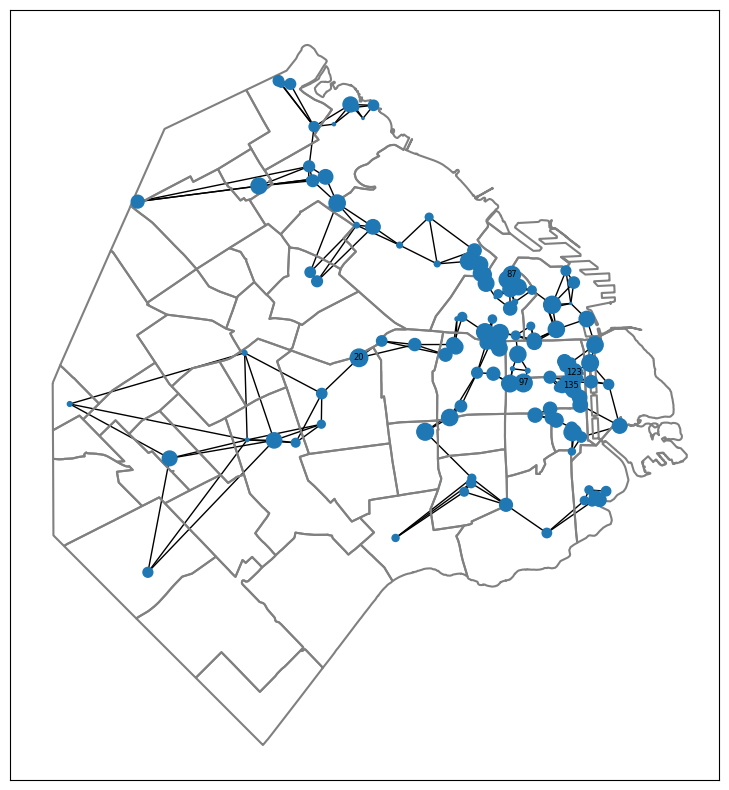

In [45]:
factor_escala = 1e4 # Escalamos los nodos 10 mil veces para que sean bien visibles
fig, ax = plt.subplots(figsize=(10, 10)) # Visualización de la red en el mapa
barrios.to_crs("EPSG:22184").boundary.plot(color='gray',ax=ax) # Graficamos Los barrios
pr = np.random.uniform(0,1,museos.shape[0])# Este va a ser su score Page Rank. Ahora lo reemplazamos con un vector al azar
pr = pr/pr.sum() # Normalizamos para que sume 1
Nprincipales = 5 # Cantidad de principales
principales = np.argsort(pr)[-Nprincipales:] # Identificamos a los N principales
labels = {n: str(n) if i in principales else "" for i, n in enumerate(G.nodes)} # Nombres para esos nodos
nx.draw_networkx(G,G_layout,node_size = pr*factor_escala, ax=ax,with_labels=False) # Graficamos red
nx.draw_networkx_labels(G, G_layout, labels=labels, font_size=6, font_color="k") # Agregamos los nombres